In [1]:
import numpy as np
import os,sys


sys.path.append('../..')
sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects_new/MarsLanding_6dof_v7/Run/Run_4km_terminal


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

6dof dynamics model
Quaternion_attitude
Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Reward_terminal
queue fixed
Flat Constraint
Attitude Constraint


<IPython.core.display.Javascript object>


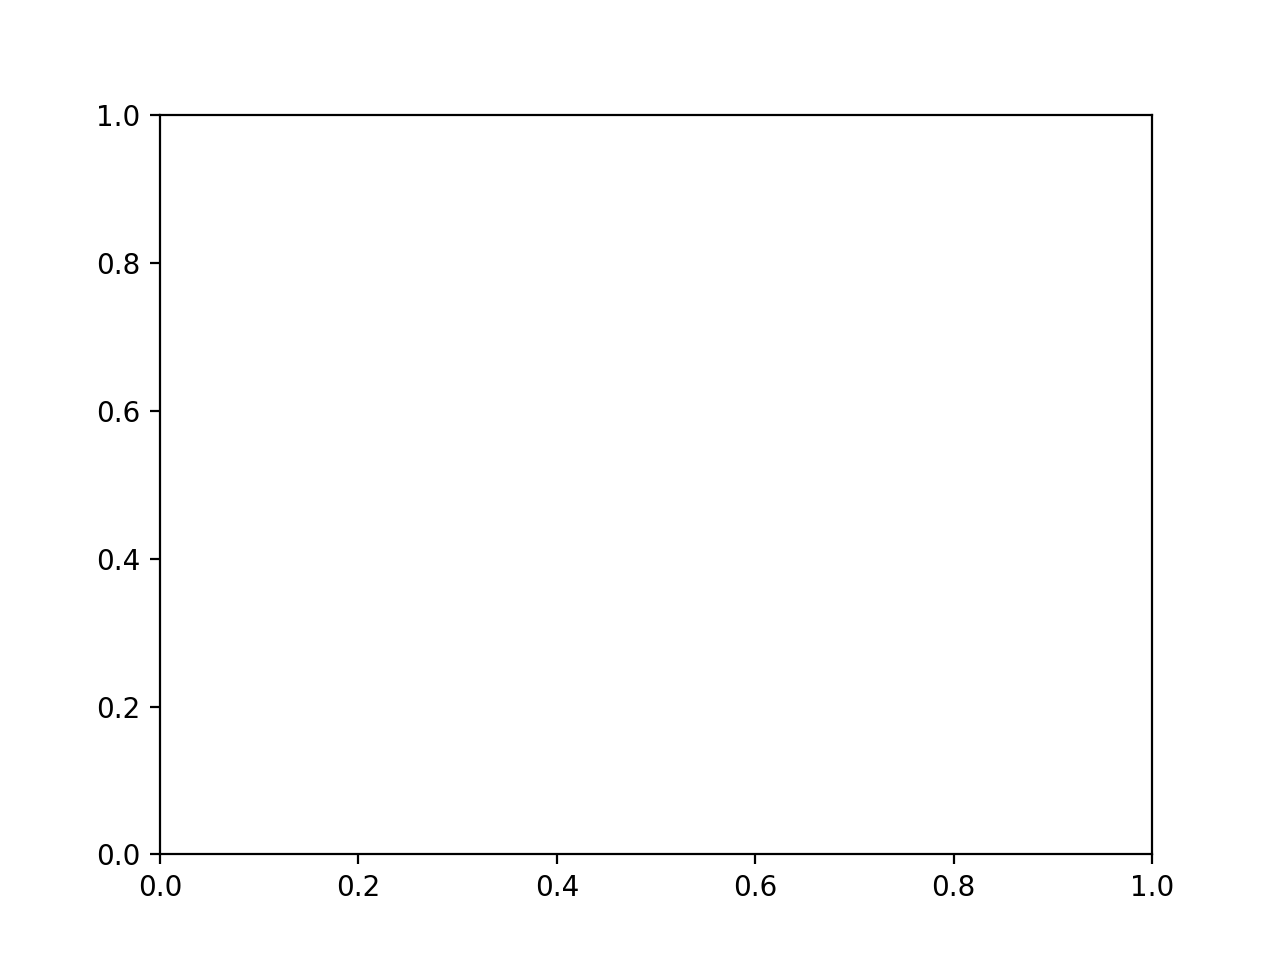

<IPython.core.display.Javascript object>


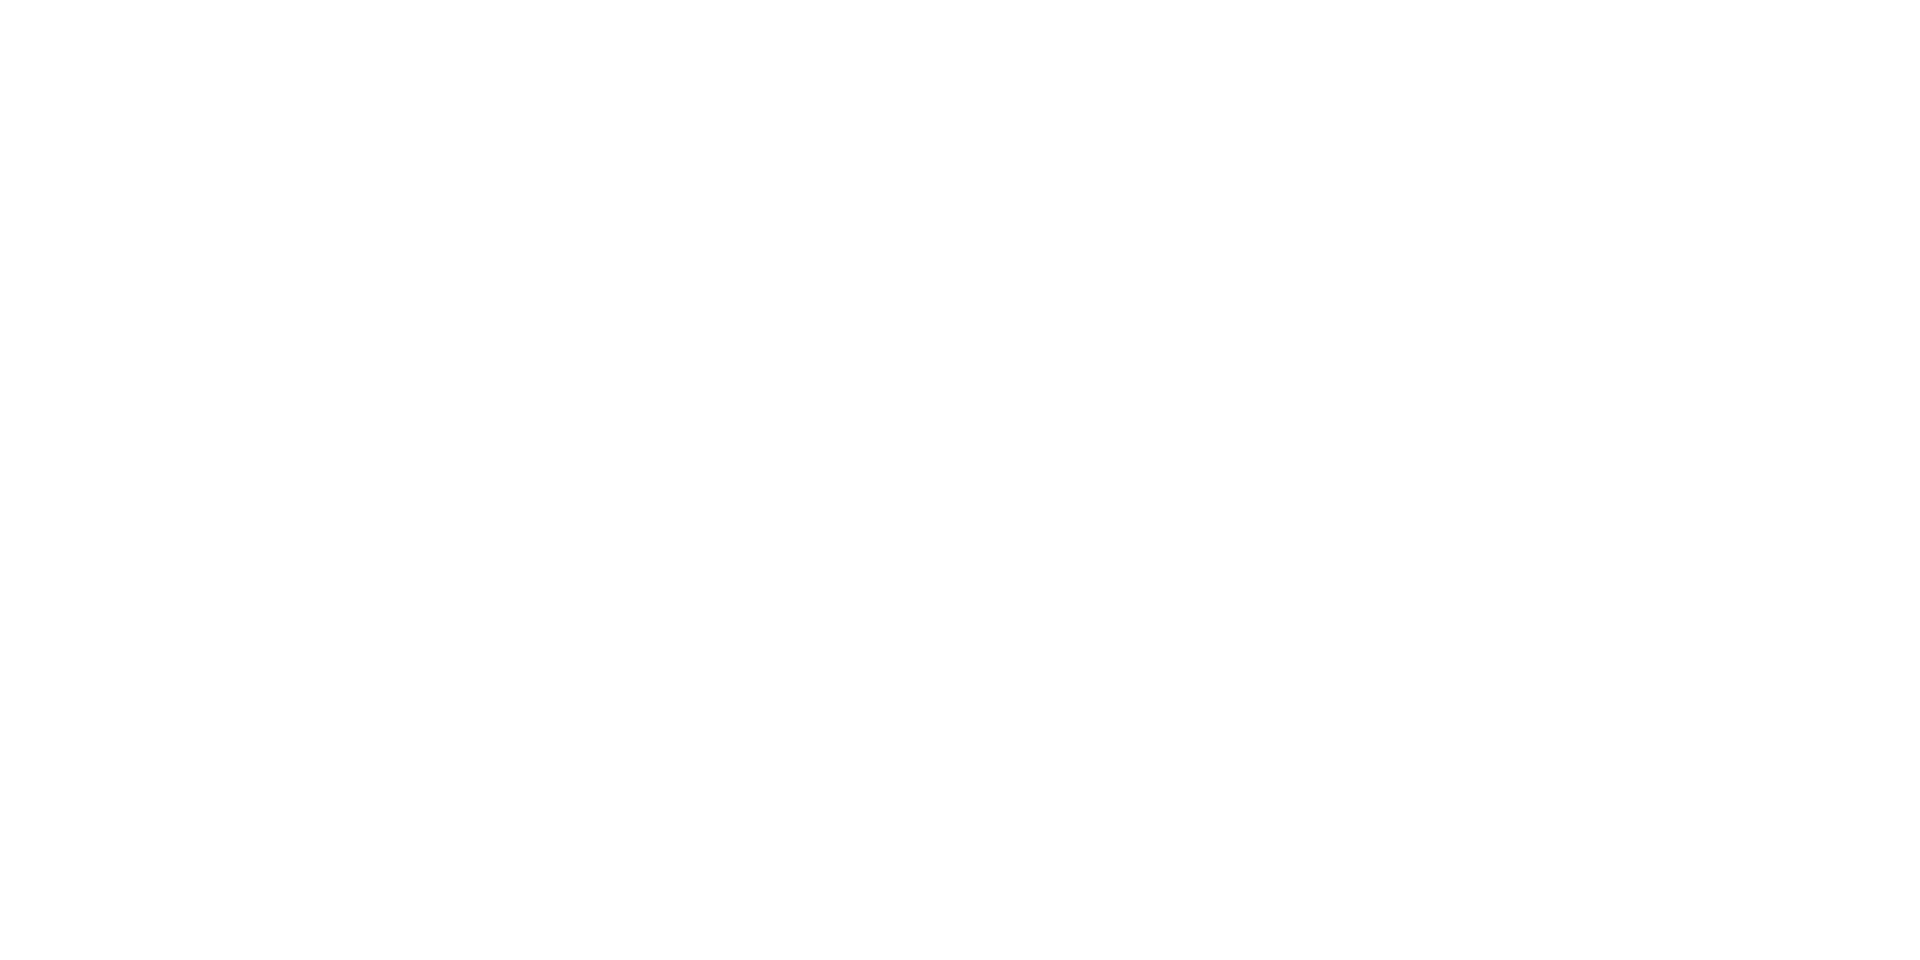

<IPython.core.display.Javascript object>


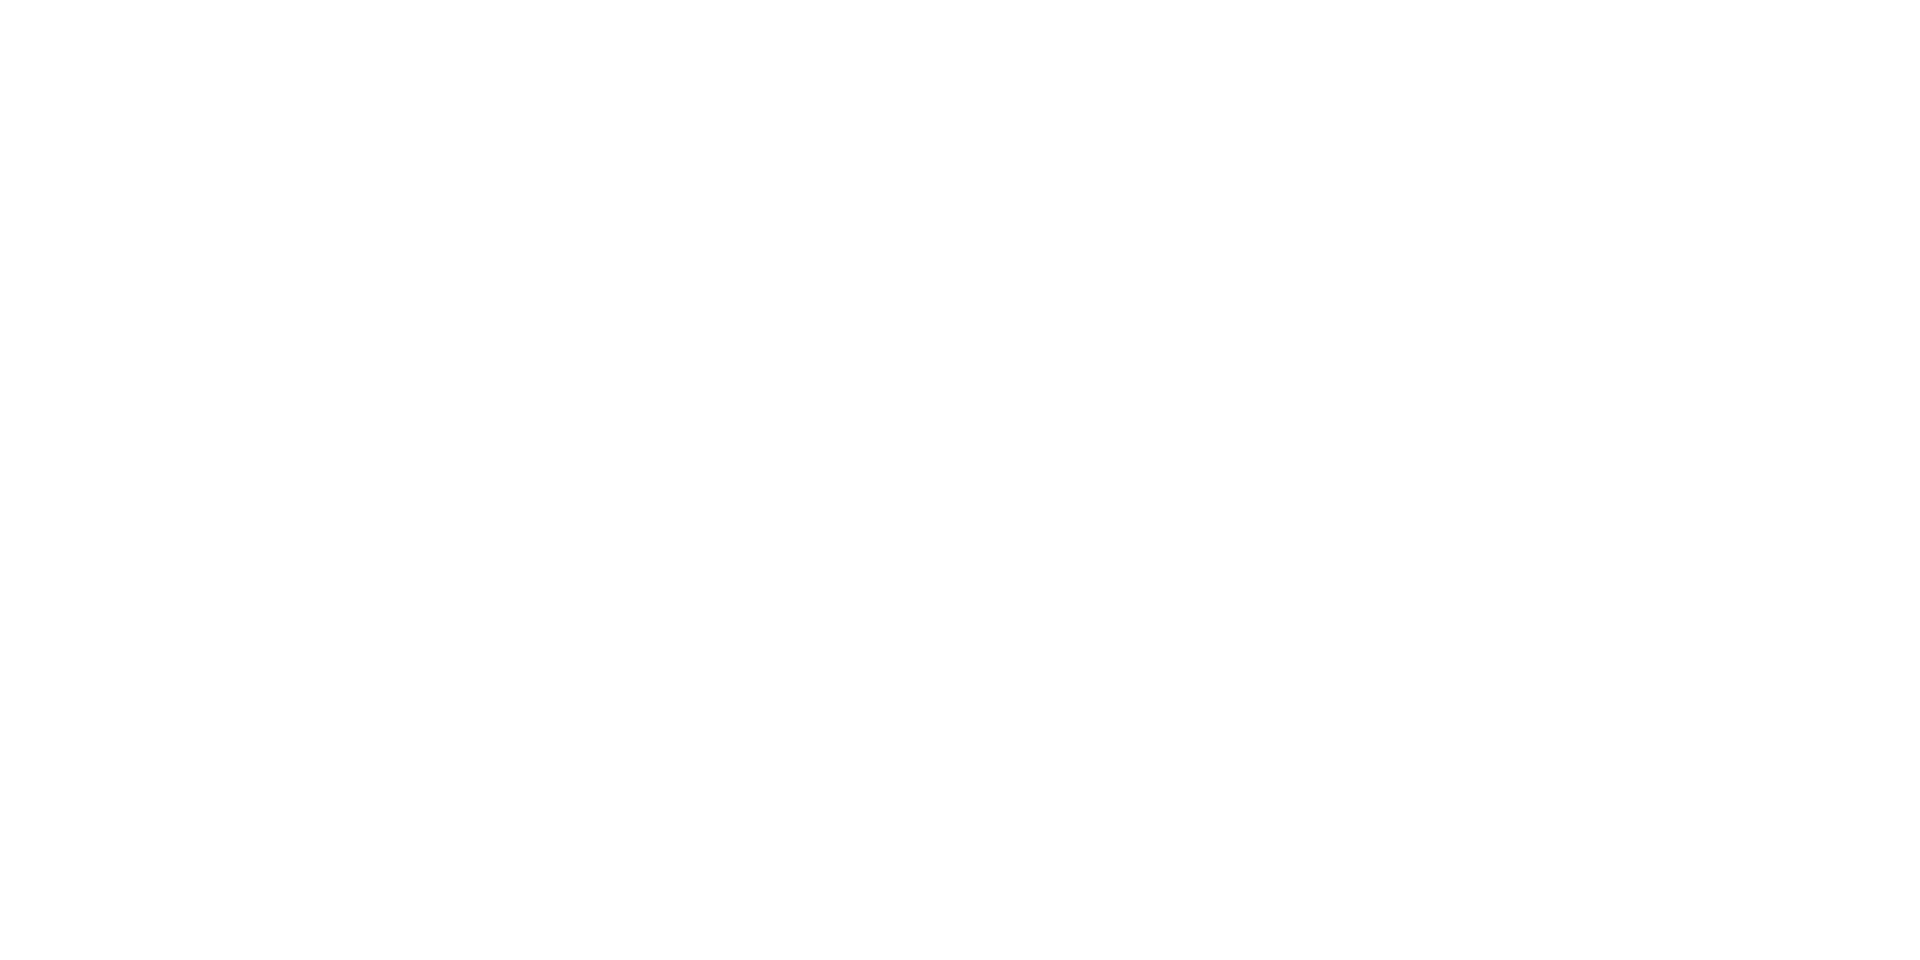

<IPython.core.display.Javascript object>


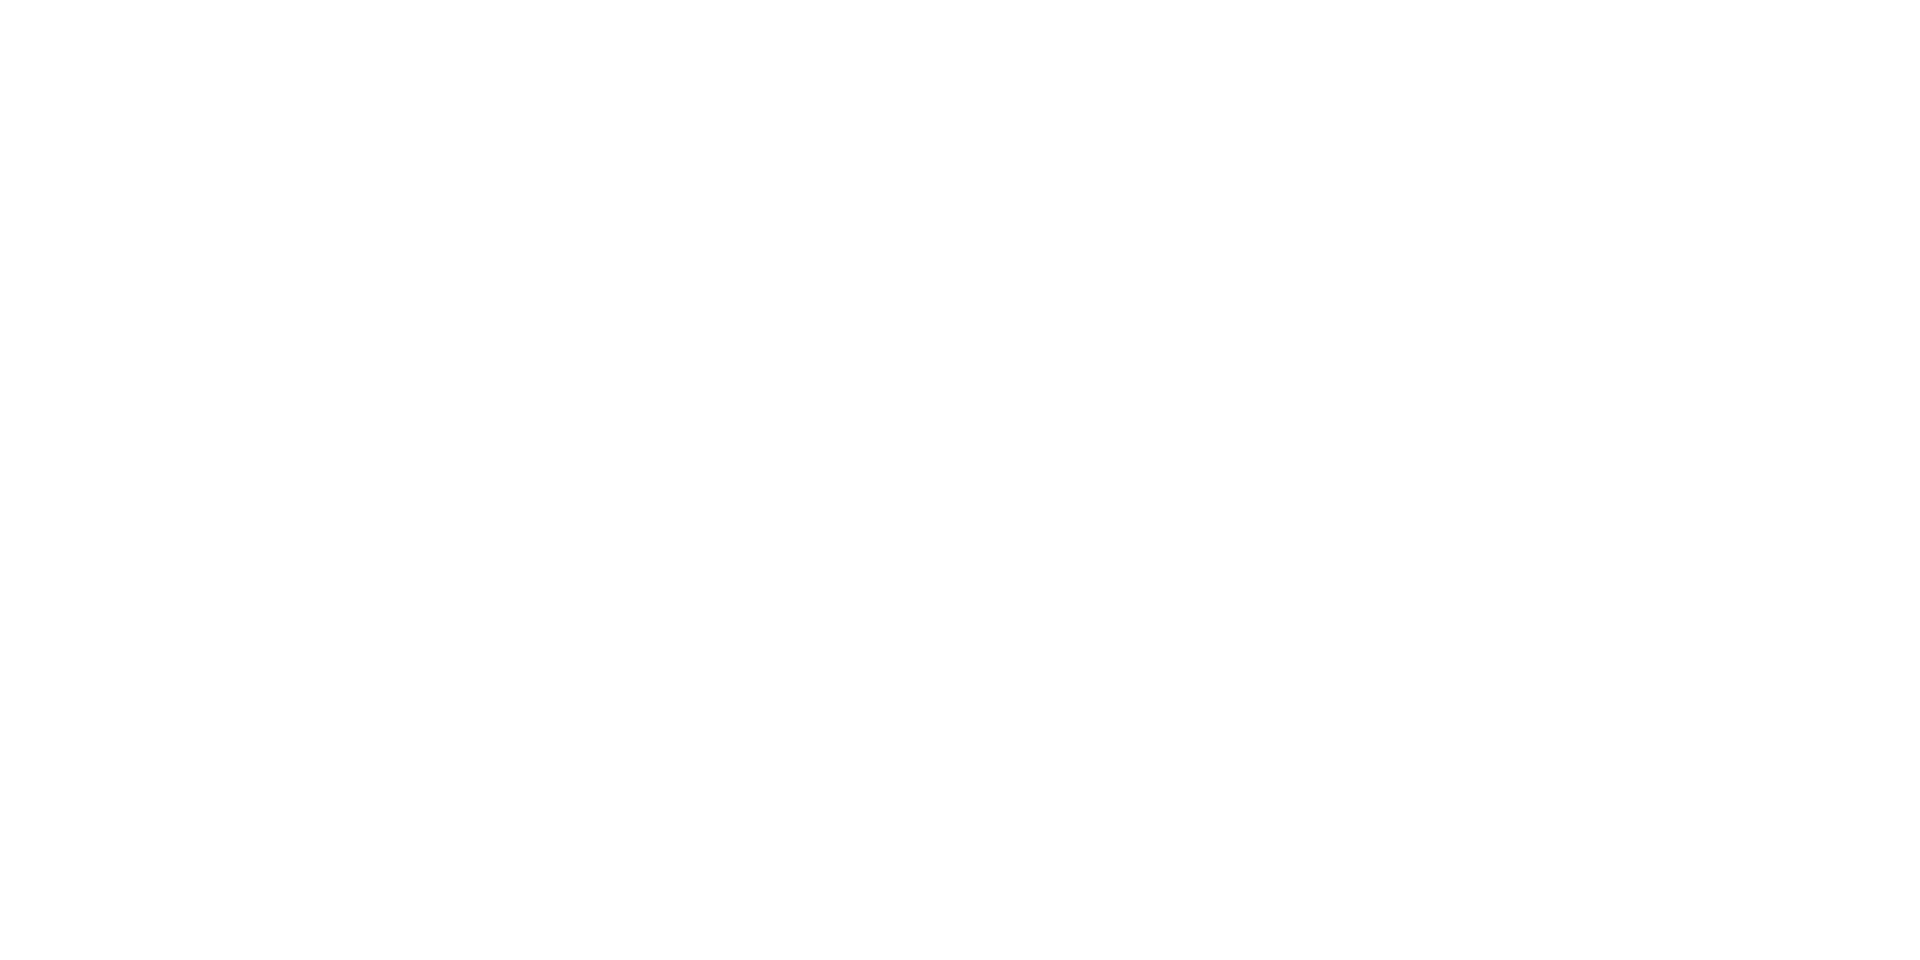

<IPython.core.display.Javascript object>


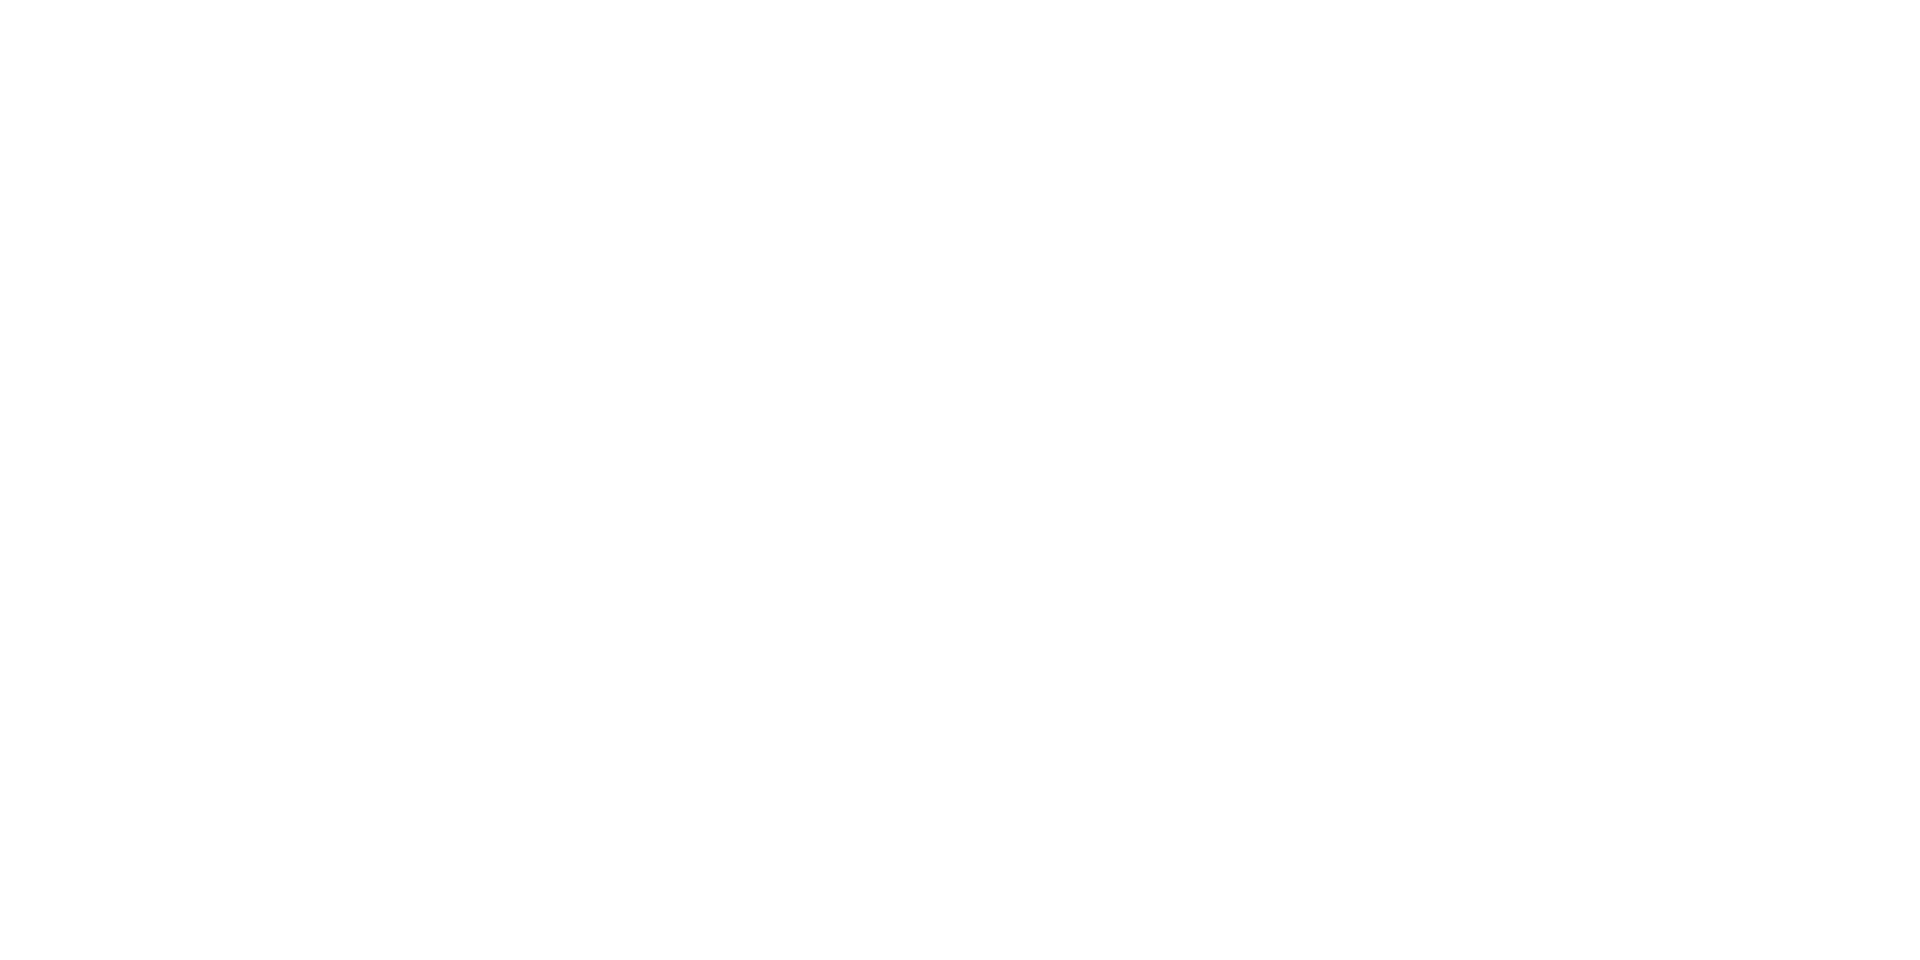

<IPython.core.display.Javascript object>


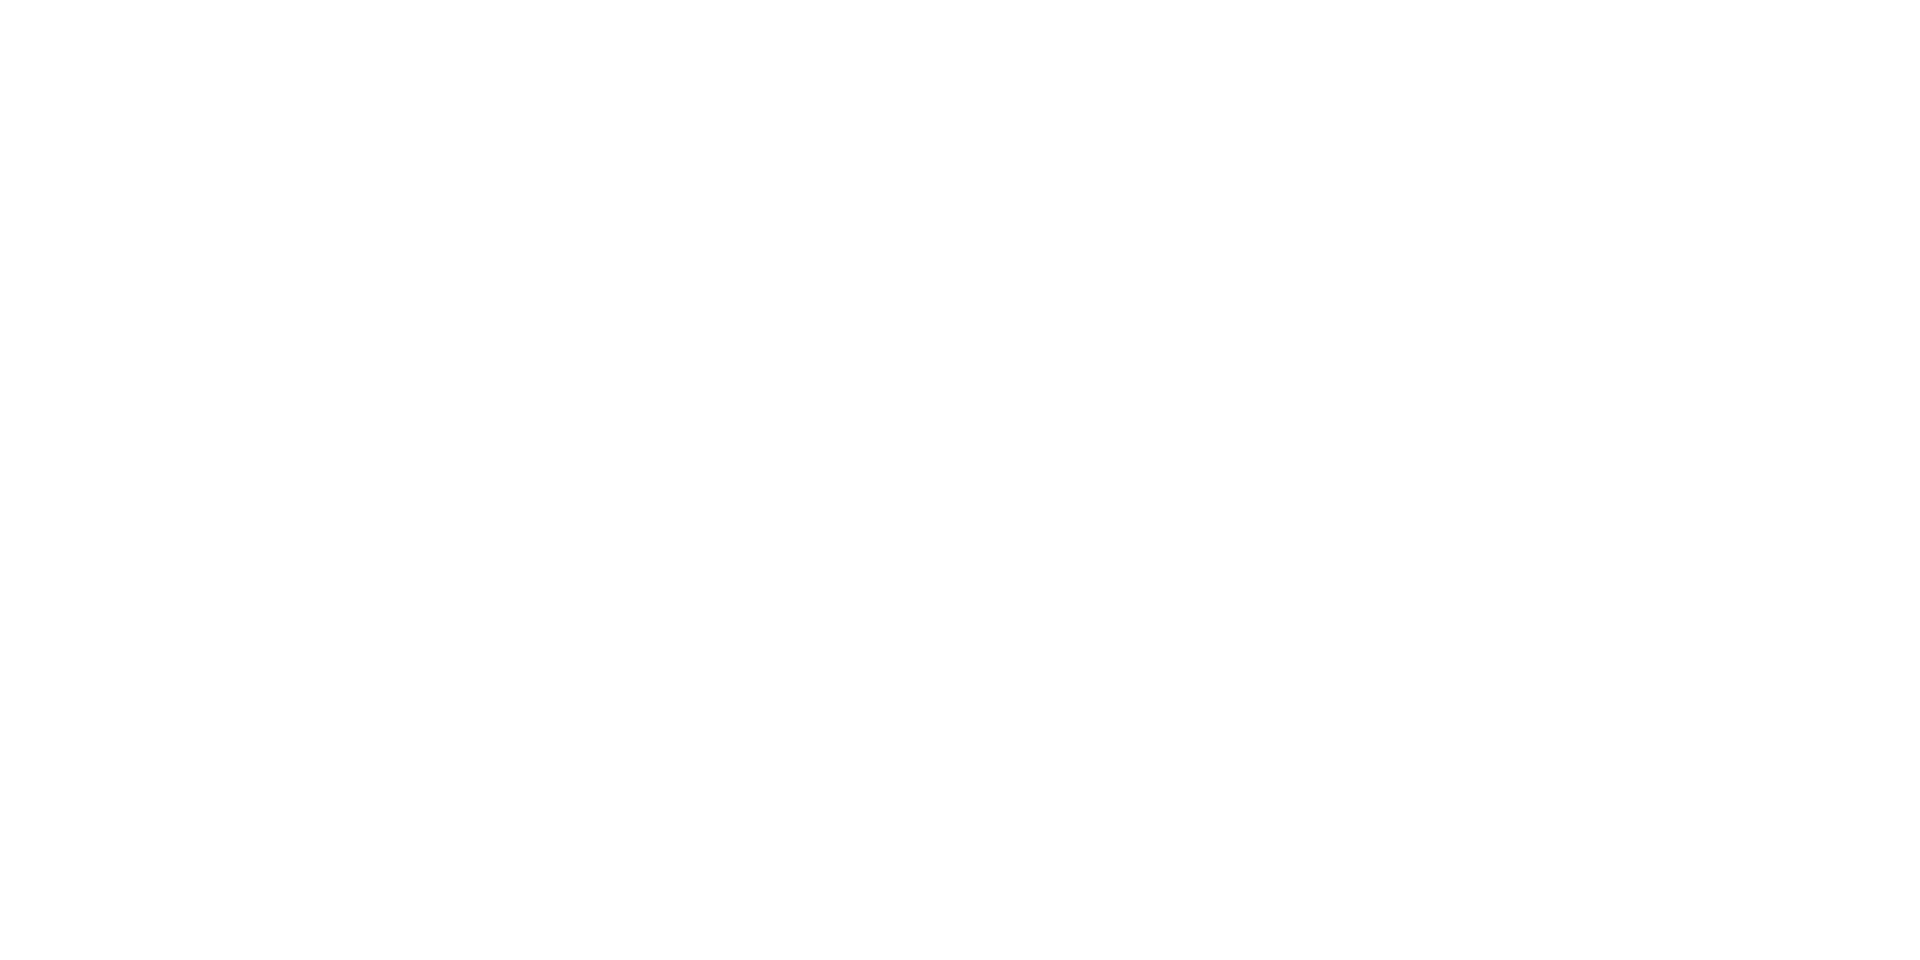

<IPython.core.display.Javascript object>


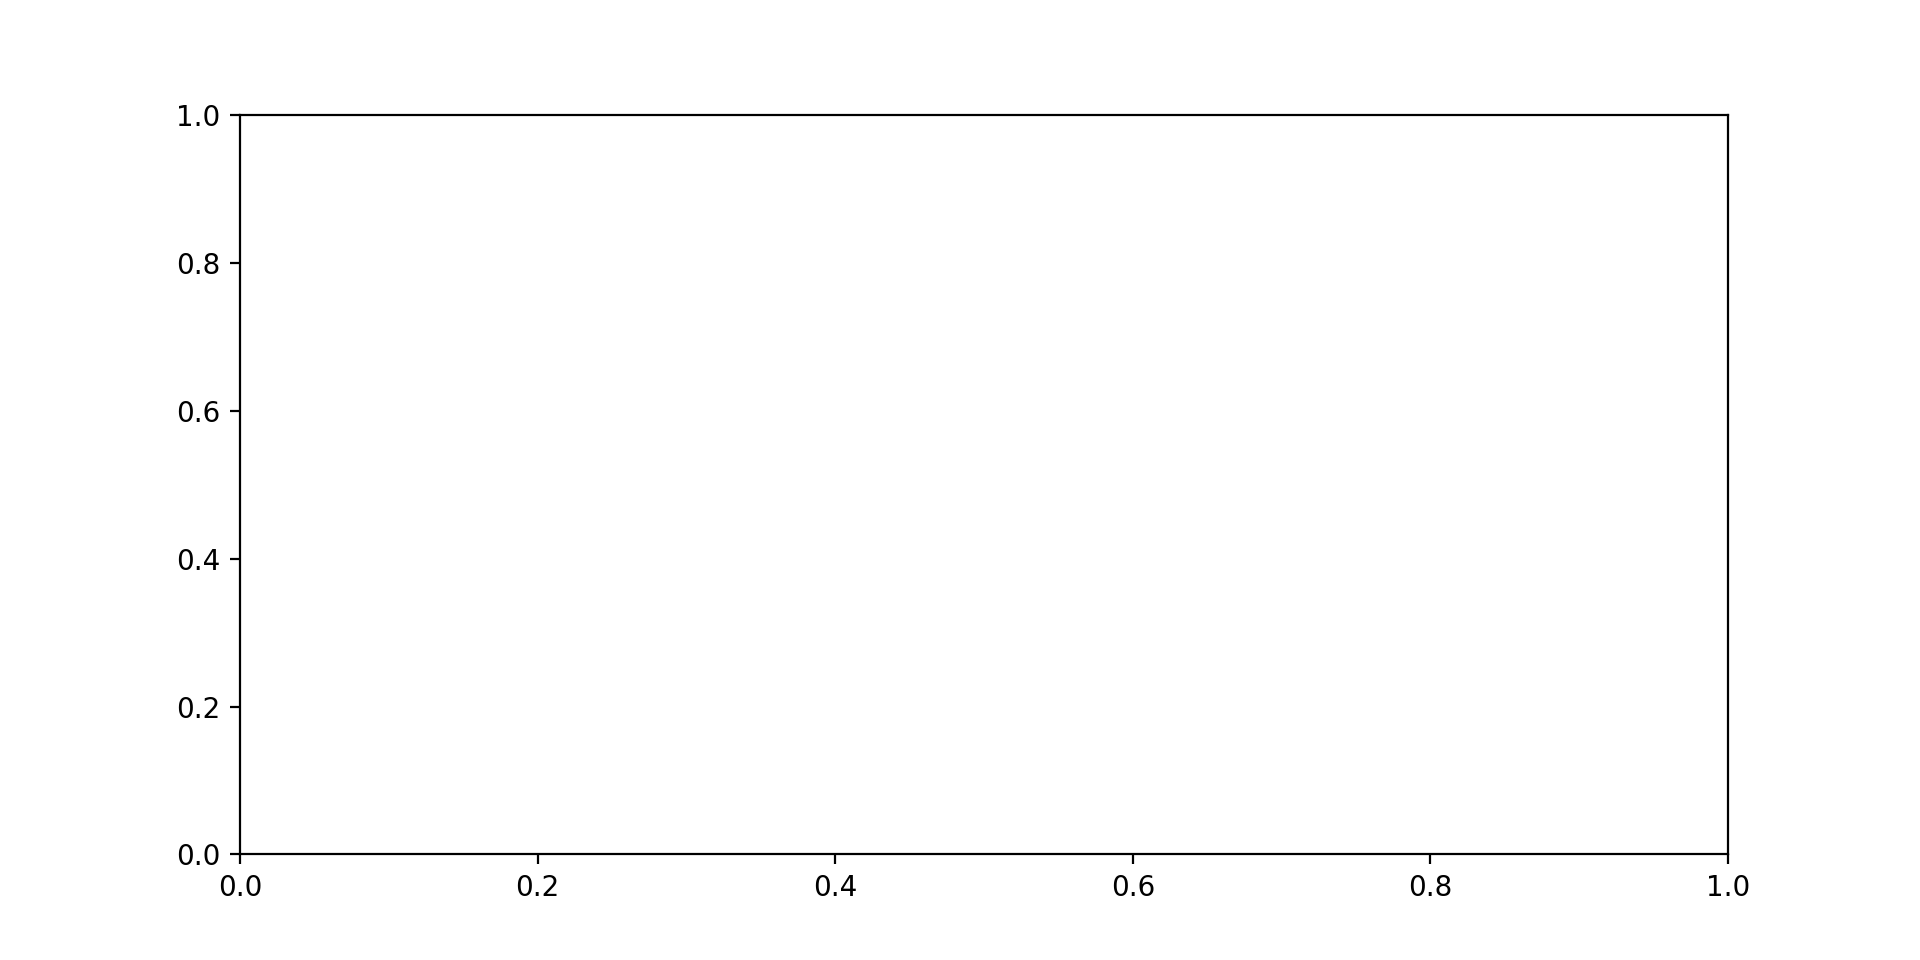

lander env att 2 fixed
PPO Policy 1
Policy Params -- h1: 120, h2: 69, h3: 40, lr: 0.000108, logvar_speed: 8
[[-1.]
 [ 0.]
 [ 1.]]
10
Actor Test Mode:  False
clip param:  0.1
dict_keys(['h1/kernel:0', 'h2/bias:0', 'h3/kernel:0', 'means/bias:0', 'h2/kernel:0', 'h3/bias:0', 'h1/bias:0', 'means/kernel:0', 'logvars:0'])


In [3]:
from env_mdr import Env
from reward_terminal_mdr  import Reward
import env_utils as envu
import attitude_utils as attu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
from agent_mdr2 import Agent
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from attitude_constraint import Attitude_constraint
from thruster_model import Thruster_model

logger = Logger()
dynamics_model = Dynamics_model()
attitude_parameterization = attu.Quaternion_attitude()


lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=15., apf_tau2=100.)
lander_model.get_state_agent = lander_model.get_state_agent_tgo_alt

reward_object = Reward(tracking_bias=0.01,tracking_coeff=-0.01, fuel_coeff=-0.05, debug=False, landing_coeff=10.)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10,
                                         attitude_limit=(10*np.pi, np.pi/2-np.pi/16, np.pi/2-np.pi/16))
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=120.0,print_every=10)




obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True)
import utils
fname = "small_reward-Copy1"
input_normalizer = utils.load_run(policy,fname)
print(input_normalizer)

In [7]:
policy.close_sess()
value_function.close_sess()

NameError: name 'value_function' is not defined

In [7]:
import utils
fname = "small_reward-Copy1"
#utils.save_run(policy,input_normalizer,fname)
utils.save_run(policy,input_normalizer,env.rl_stats.history,fname)

Saved Vars:  ['h1/kernel:0', 'h1/bias:0', 'h2/kernel:0', 'h2/bias:0', 'h3/kernel:0', 'h3/bias:0', 'means/kernel:0', 'means/bias:0', 'logvars:0']


In [6]:
print(input_normalizer)

None


# Test Policy with Realistic Noise
## we slightly relax glideslope constraint

In [4]:
policy.test_mode=True
env.glideslope_constraint.gs_limit=0.00
env.lander=lander_model
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (1900,2100,-90,-70),
                           yaw   = (-np.pi/16, np.pi/16, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/16, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/16, np.pi/16, -0.0, 0.0),
                          noise_u=50*np.ones(3), noise_sd=50*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10093.10 |2708.61 |3200.00 |16000.00 |    58
glideslope | 3.550 |13.750 | 0.756 |1488.860 |    32
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.3     0.0    -0.0 |     0.4     0.3     0.0 |    -1.3    -0.4    -0.0 |     2.0     1.6    -0.0
velocity |   0.048  -0.028  -0.961 |   0.017   0.056   0.037 |   0.016  -0.122  -1.043 |   0.104   0.119  -0.859
fuel     |272.95 | 13.44 |250.72 |311.10
attitude_321 |  -0.055  -0.027  -0.017 |   0.135   0.010   0.020 |  -0.386  -0.056  -0.051 |   0.342   0.020   0.037
w        |  -0.037  -0.013   0.000 |   0.052   0.026   0.000 |  -0.159  -0.127  -0.000 |   0.081   0.026   0.000
glideslope |  20.773 |   6.381 |  11.559 |  44.029
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |10046.16 |2759.15 |3200.00 |16000.00 |    58
glideslope | 3.397 |10.594 | 0.590 |1488.860 |    32
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |10058.80 |2766.08 |3200.00 |16000.00 |   560
glideslope | 3.526 |11.743 | 0.214 |4420.654 |   890
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.4     0.4     0.0 |    -1.3    -2.6    -0.1 |     2.8     2.0    -0.0
velocity |   0.045  -0.020  -0.953 |   0.017   0.057   0.041 |  -0.023  -0.144  -1.065 |   0.104   0.121  -0.814
fuel     |276.43 | 15.58 |244.96 |344.06
attitude_321 |  -0.059  -0.026  -0.017 |   0.131   0.009   0.022 |  -0.400  -0.061  -0.066 |   0.422   0.020   0.056
w        |  -0.028  -0.009  -0.000 |   0.049   0.023   0.000 |  -0.169  -0.127  -0.000 |   0.089   0.057   0.000
glideslope |  19.888 |   6.603 |  10.265 |  64.688
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |10069.93 |2771.24 |3200.00 |16000.00 |   560
glideslope | 3.527 |11.462 | 0.214 |4420.654 |   890
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |10074.69 |2773.62 |3200.00 |16000.00 |   560
glideslope | 3.517 |10.066 | 0.214 |4420.654 |   890
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -1.8    -2.7    -0.1 |     2.8     2.5    -0.0
velocity |   0.046  -0.021  -0.954 |   0.017   0.058   0.042 |  -0.023  -0.144  -1.065 |   0.104   0.215  -0.780
fuel     |276.38 | 15.44 |244.96 |344.06
attitude_321 |  -0.056  -0.027  -0.017 |   0.133   0.009   0.021 |  -0.400  -0.067  -0.066 |   0.423   0.027   0.061
w        |  -0.028  -0.010  -0.000 |   0.050   0.024   0.000 |  -0.169  -0.165  -0.000 |   0.099   0.084   0.000
glideslope |  20.018 |   7.282 |  10.265 | 120.025
i :  2400
Cumulative Stats (mean,std,max,argmax)
thrust   |10070.31 |2773.23 |3200.00 |16000.00 |   560
glideslope | 3.507 | 9.949 | 0.214 |4420.654 |   890
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0


i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |10070.84 |2770.57 |3200.00 |16000.00 |   560
glideslope | 3.577 |25.613 | 0.214 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -1.8    -3.4    -0.1 |     2.8     3.8    -0.0
velocity |   0.046  -0.020  -0.954 |   0.017   0.058   0.041 |  -0.023  -0.144  -1.065 |   0.111   0.215  -0.780
fuel     |276.33 | 15.35 |244.96 |344.06
attitude_321 |  -0.057  -0.027  -0.017 |   0.133   0.010   0.021 |  -0.400  -0.068  -0.066 |   0.423   0.027   0.062
w        |  -0.028  -0.010  -0.000 |   0.051   0.024   0.000 |  -0.169  -0.165  -0.000 |   0.099   0.084   0.000
glideslope |  20.046 |   7.270 |  10.265 | 120.025
i :  3500
Cumulative Stats (mean,std,max,argmax)
thrust   |10069.98 |2769.72 |3200.00 |16000.00 |   560
glideslope | 3.592 |25.378 | 0.214 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     

i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |10071.96 |2775.31 |3200.00 |16000.00 |   560
glideslope | 3.540 |22.652 | 0.214 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -1.8    -3.4    -0.1 |     2.8     3.8    -0.0
velocity |   0.046  -0.021  -0.954 |   0.017   0.058   0.042 |  -0.023  -0.150  -1.065 |   0.111   0.215  -0.780
fuel     |276.46 | 15.31 |244.96 |346.71
attitude_321 |  -0.055  -0.027  -0.017 |   0.132   0.010   0.021 |  -0.400  -0.068  -0.066 |   0.423   0.027   0.062
w        |  -0.028  -0.010  -0.000 |   0.050   0.024   0.000 |  -0.174  -0.165  -0.000 |   0.099   0.084   0.000
glideslope |  20.035 |   7.314 |   9.896 | 120.025
i :  4600
Cumulative Stats (mean,std,max,argmax)
thrust   |10072.22 |2774.98 |3200.00 |16000.00 |   560
glideslope | 3.541 |22.474 | 0.214 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     

i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |10072.70 |2774.59 |3200.00 |16000.00 |   560
glideslope | 3.516 |20.684 | 0.214 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -1.8    -3.4    -0.1 |     2.8     3.8    -0.0
velocity |   0.046  -0.021  -0.954 |   0.017   0.058   0.042 |  -0.023  -0.150  -1.065 |   0.111   0.215  -0.780
fuel     |276.34 | 15.32 |244.96 |346.71
attitude_321 |  -0.055  -0.027  -0.017 |   0.133   0.010   0.021 |  -0.400  -0.068  -0.066 |   0.441   0.027   0.062
w        |  -0.028  -0.010  -0.000 |   0.051   0.024   0.000 |  -0.178  -0.165  -0.000 |   0.099   0.084   0.000
glideslope |  20.041 |   7.148 |   9.657 | 120.025
i :  5700
Cumulative Stats (mean,std,max,argmax)
thrust   |10075.25 |2776.24 |3200.00 |16000.00 |   560
glideslope | 3.513 |20.531 | 0.083 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     

i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |10074.02 |2778.40 |3200.00 |16000.00 |   560
glideslope | 3.515 |19.168 | 0.083 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -2.8    -3.4    -0.1 |     2.8    11.3    -0.0
velocity |   0.046  -0.021  -0.954 |   0.017   0.059   0.042 |  -0.046  -0.557  -1.121 |   0.324   0.215  -0.780
fuel     |276.54 | 15.44 |244.96 |346.71
attitude_321 |  -0.056  -0.027  -0.017 |   0.132   0.010   0.021 |  -0.448  -0.068  -0.098 |   0.480   0.027   0.062
w        |  -0.028  -0.010  -0.000 |   0.051   0.024   0.000 |  -0.228  -0.265  -0.000 |   0.125   0.084   0.000
glideslope |  20.057 |   7.476 |   5.025 | 178.998
i :  6800
Cumulative Stats (mean,std,max,argmax)
thrust   |10075.99 |2778.33 |3200.00 |16000.00 |   560
glideslope | 3.516 |19.051 | 0.083 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     

i :  7800
Cumulative Stats (mean,std,max,argmax)
thrust   |10072.70 |2776.59 |3200.00 |16000.00 |   560
glideslope | 3.559 |19.701 | 0.083 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     1.2     3.3     0.0 |   -94.0  -285.4    -0.1 |     2.8    11.3    -0.0
velocity |   0.047  -0.016  -0.956 |   0.060   0.433   0.160 |  -0.046  -0.557 -14.572 |   5.114  37.831  -0.780
fuel     |276.45 | 15.47 |222.95 |346.71
attitude_321 |  -0.055  -0.027  -0.017 |   0.131   0.010   0.022 |  -0.448  -0.068  -0.098 |   0.480   0.137   0.516
w        |  -0.028  -0.010  -0.000 |   0.052   0.024   0.000 |  -0.228  -0.332  -0.000 |   0.793   0.084   0.000
glideslope |  20.069 |   7.392 |   0.389 | 178.998
i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |10073.49 |2776.69 |3200.00 |16000.00 |   560
glideslope | 3.561 |19.600 | 0.083 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     

i :  8900
Cumulative Stats (mean,std,max,argmax)
thrust   |10075.84 |2776.34 |3200.00 |16000.00 |   560
glideslope | 3.550 |18.679 | 0.083 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     1.8     4.5     0.0 |  -136.2  -318.3    -0.8 |     2.8    11.3    -0.0
velocity |   0.048  -0.014  -0.958 |   0.091   0.503   0.241 |  -0.046  -0.557 -18.764 |   6.766  37.831  -0.780
fuel     |276.46 | 15.52 |218.66 |346.71
attitude_321 |  -0.055  -0.027  -0.017 |   0.131   0.010   0.022 |  -0.448  -0.068  -0.098 |   0.480   0.137   0.516
w        |  -0.028  -0.010  -0.000 |   0.052   0.024   0.000 |  -0.228  -0.332  -0.000 |   0.793   0.084   0.000
glideslope |  20.095 |   7.387 |   0.389 | 178.998
i :  9000
Cumulative Stats (mean,std,max,argmax)
thrust   |10077.06 |2777.40 |3200.00 |16000.00 |   560
glideslope | 3.548 |18.591 | 0.083 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     


Cumulative Stats (mean,std,max,argmax)
thrust   |10076.69 |2777.29 |3200.00 |16000.00 |   560
glideslope | 3.534 |17.799 | 0.083 |22121.508 |  2605
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.0    -0.0 |     1.7     4.3     0.0 |  -136.2  -318.3    -0.8 |     2.8    11.3    -0.0
velocity |   0.047  -0.015  -0.958 |   0.086   0.475   0.228 |  -0.046  -0.557 -18.764 |   6.766  37.831  -0.780
fuel     |276.53 | 15.52 |218.66 |346.71
attitude_321 |  -0.055  -0.027  -0.017 |   0.131   0.010   0.022 |  -0.462  -0.068  -0.098 |   0.480   0.137   0.516
w        |  -0.028  -0.010  -0.000 |   0.052   0.024   0.000 |  -0.228  -0.332  -0.000 |   0.793   0.084   0.000
glideslope |  20.080 |   7.393 |   0.389 | 178.998

Initial Stats (mean,std,min,max)
position |  1002.2     0.4  1999.1 |   577.0   578.1    57.6 |     0.4 -1000.0  1900.0 |  1999.8   999.3  2100.0
velocity | -39.954  -0.131 -80.083 |  17.360  17.217   5.740 | -69.998 

In [ ]:
policy.test_mode=True
env.glideslope_constraint.gs_limit=0.00
env.lander=lander_model
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (1900,2100,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=100*np.ones(3), noise_sd=50*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model fixed:  15000
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  10.0
 - apf_tau1:  20
 - apf_tau2:  250
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10432.67 |2776.90 |3200.00 |16000.00 |    20
glideslope | 3.791 | 7.689 | 1.014 |480.300 |    17
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |   300.0  -300.6    -0.0 |     0.3     0.4     0.0 |   299.6  -302.0    -0.0 |   301.1  -299.5    -0.0
velocity |  -0.069  -0.064  -0.900 |   0.014   0.026   0.074 |  -0.101  -0.124  -1.042 |  -0.031  -0.014  -0.657
fuel     |272.52 | 11.21 |253.00 |316.11
attitude |  -0.099  -0.001   0.001 |   0.045   0.005   0.011 |  -0.220  -0.013  -0.041 |   0.120   0.016   0.022
w        |   0.009   0.010   0.000 |   0.025   0.014   0.000 |  -0.054  -0.022  -0.000 |   0.082   0.060   0.000
gl

<IPython.core.display.Javascript object>


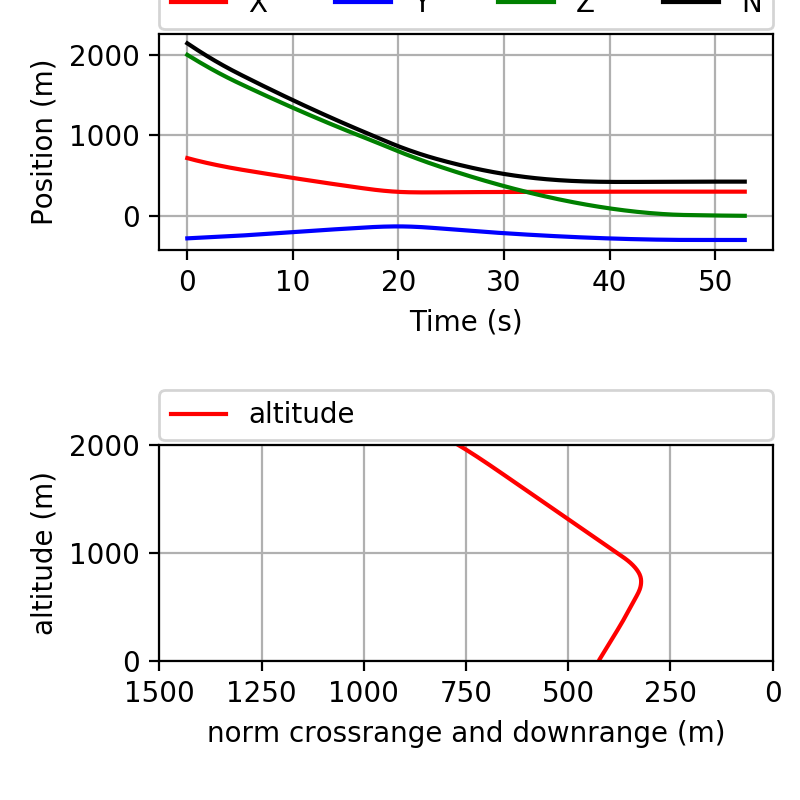

In [63]:
from lander_model2 import Lander_model
lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=10., divert=(300,-300,1000))
lander_model.get_state_agent = lander_model.get_state_agent9
lander_model.apf_pot = lander_model.apf_pot4
env.lander=lander_model

policy.test_mode=True
env.glideslope_constraint.gs_limit=0.00
env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           downrange = (500,1500 , -70, -10), 
                           crossrange = (-500,500 , -30,30),  
                           altitude = (2000,2000,-90,-70),
                          noise_u=20*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,1000,print_every=100)
envu.render_traj(lander_model.trajectory_list[0])

In [64]:
envu.render_traj(lander_model.trajectory_list[10])

Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model fixed:  15000
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  10.0
 - apf_tau1:  20
 - apf_tau2:  250

Cumulative Stats (mean,std,max,argmax)
thrust   |10407.56 |3115.16 |3464.10 |16000.00 |     0
glideslope | 1.514 | 2.099 | 0.859 |16.097 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.7     0.3    -0.0 |     0.0     0.0     0.0 |    -0.7     0.3    -0.0 |    -0.7     0.3    -0.0
velocity |  -0.103  -0.125  -0.894 |   0.000   0.000   0.000 |  -0.103  -0.125  -0.894 |  -0.103  -0.125  -0.894
fuel     |279.54 |  0.00 |279.54 |279.54
attitude |   0.281   0.009   0.013 |   0.000   0.000   0.000 |   0.281   0.009   0.013 |   0.281   0.009   0.013
w        |  -0.002   0.000   0.000 |   0.000   0.000   0.000 |  -0.002   0.000   0.000 |  -0.002   0.000   0.000
glideslope 

<IPython.core.display.Javascript object>


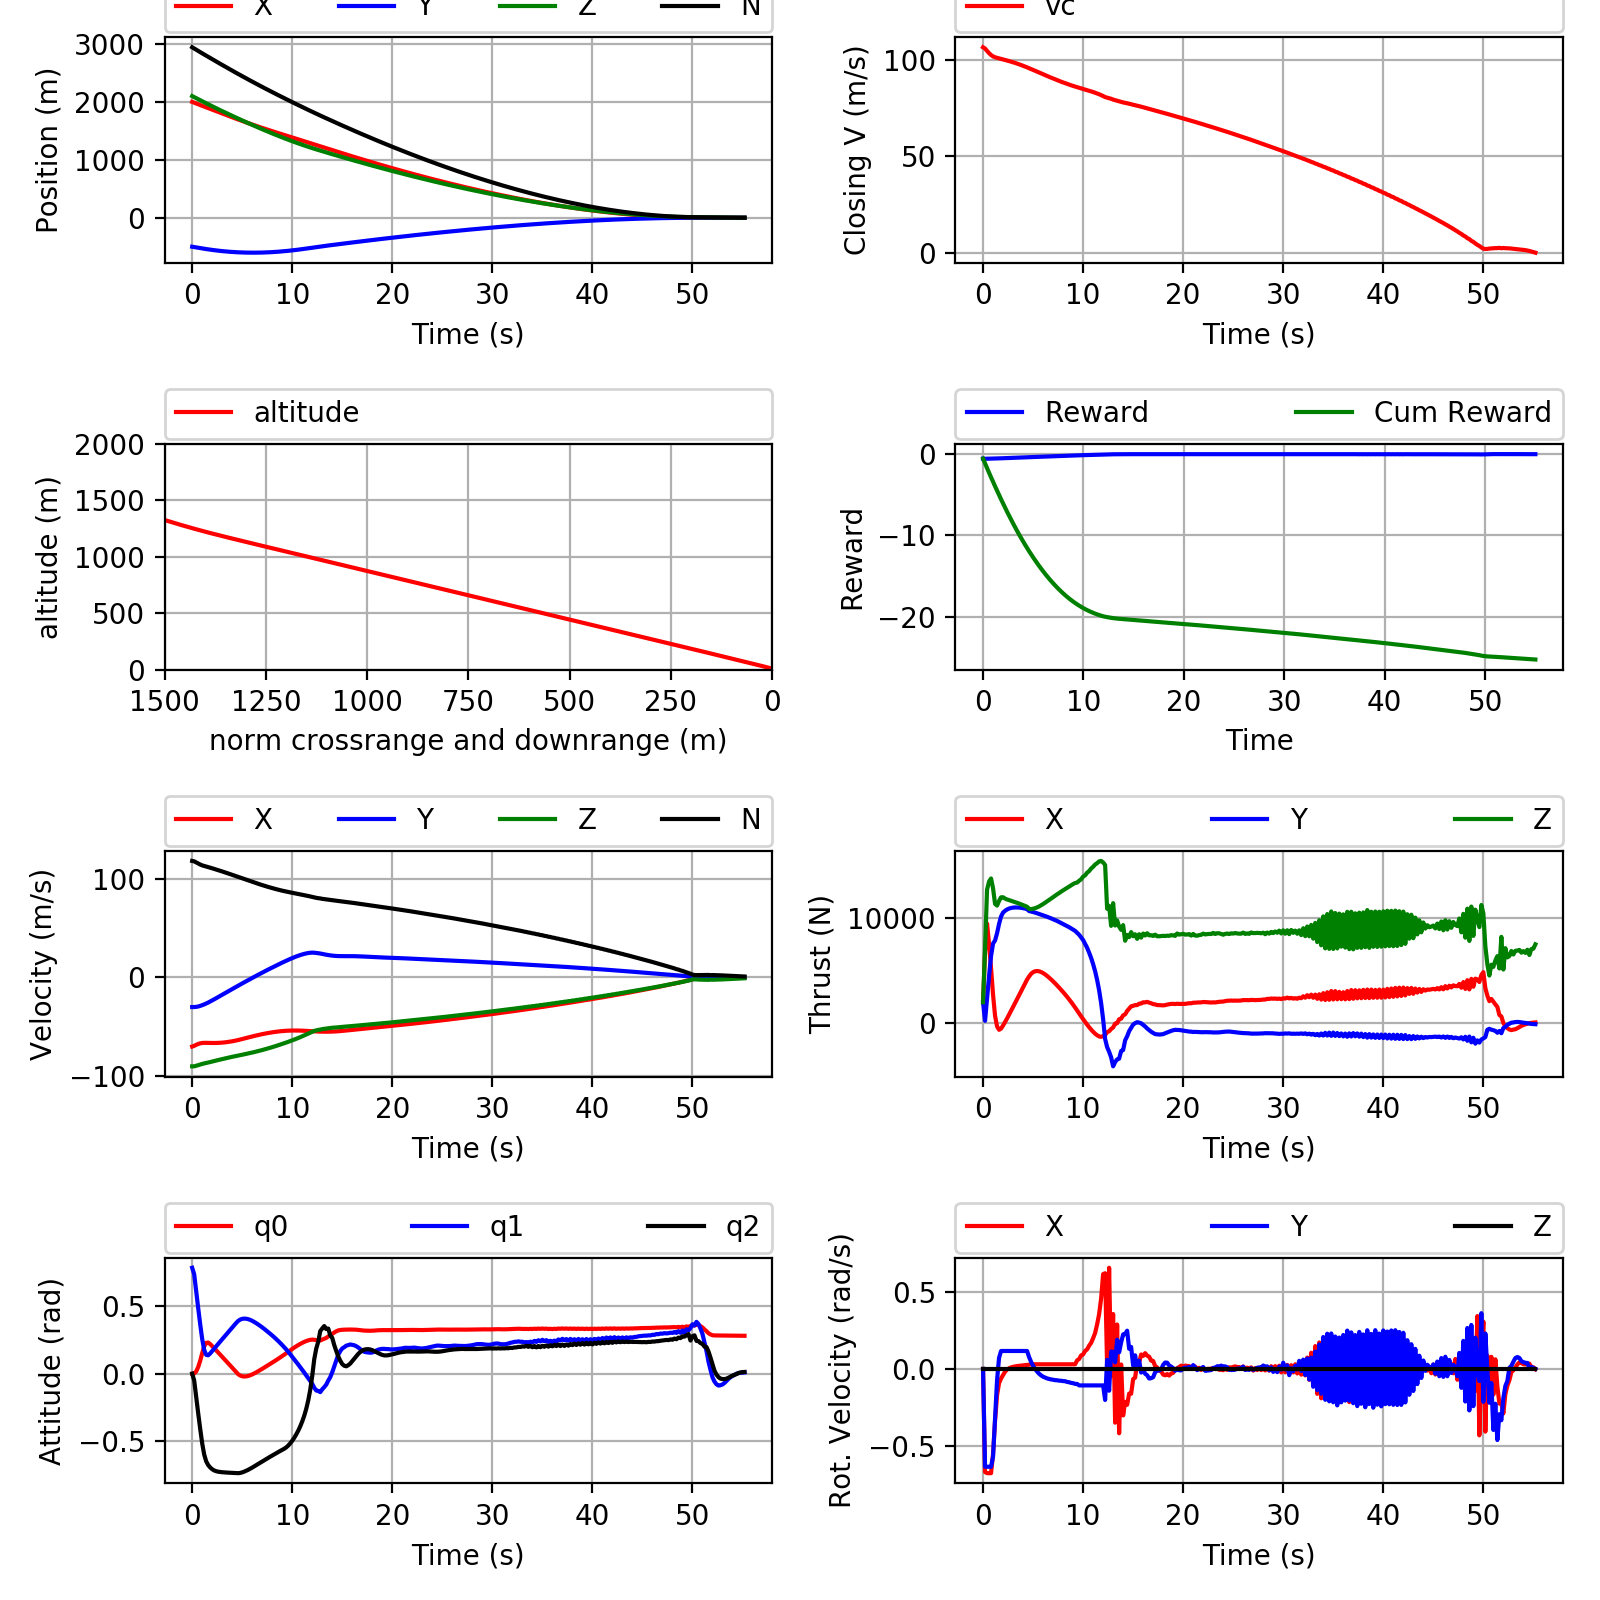

In [66]:
policy.test_mode=True
env.glideslope_constraint.gs_limit=0.00
lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=10.)
lander_model.get_state_agent = lander_model.get_state_agent9
env.lander=lander_model
env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           downrange = (1500,1500 , -70, -70), 
                           crossrange = (-500,-500 , -30,-30),  
                           altitude = (2100,2100,-90,-90),
                          noise_u=20*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,1,print_every=1)
envu.render_traj(lander_model.trajectory_list[0])

In [83]:
policy.test_mode=True
env.glideslope_constraint.gs_limit=0.00
lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=10.)
lander_model.get_state_agent = lander_model.get_state_agent9
env.lander=lander_model
env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           downrange = (500,2500 , -70, -10), 
                           crossrange = (-500,500 , -0,0),  
                           altitude = (1900,2100,-90,-70),
                          noise_u=20*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)
#envu.render_traj(lander_model.trajectory_list[0])

Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model fixed:  15000
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  10.0
 - apf_tau1:  20
 - apf_tau2:  250
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9619.11 |2674.05 |3200.00 |16000.00 |    95
glideslope | 2.271 | 6.434 | 0.626 |843.702 |    21
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.2     0.0 |    -1.8    -0.7    -0.0 |     1.1     0.5    -0.0
velocity |  -0.071  -0.105  -0.815 |   0.015   0.024   0.079 |  -0.118  -0.169  -1.090 |  -0.034  -0.024  -0.639
fuel     |284.16 | 22.49 |247.03 |347.56
attitude |  -0.008   0.004  -0.007 |   0.073   0.007   0.011 |  -0.145  -0.009  -0.036 |   0.230   0.022   0.018
w        |  -0.010   0.003   0.000 |   0.021   0.013   0.000 |  -0.057  -0.030  -0.000 |   0.060   0.039   0.000
gli

position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.5    -1.0    -0.0 |     1.3     1.0    -0.0
velocity |  -0.072  -0.106  -0.823 |   0.015   0.024   0.074 |  -0.119  -0.177  -1.090 |   0.009   0.009  -0.473
fuel     |282.46 | 22.50 |241.33 |365.23
attitude |  -0.010   0.004  -0.006 |   0.079   0.006   0.011 |  -0.283  -0.016  -0.036 |   0.324   0.025   0.033
w        |  -0.012   0.004   0.000 |   0.020   0.014   0.000 |  -0.066  -0.110  -0.000 |   0.093   0.080   0.000
glideslope |   9.348 |   1.453 |   6.460 |  18.491
i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9755.91 |2718.25 |3200.00 |16000.00 |    95
glideslope | 2.360 | 5.372 | 0.455 |1008.860 |   106
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.5    -1.0    -0.0 |     1.6     1.0    -0.0
velocity |  -0.072  -0.106  -0.823 |   0.015   0.024   0.074 |  -0.119  -0.177  -1.090 |   0.009   0.0

i :  2200
Cumulative Stats (mean,std,max,argmax)
thrust   |9759.28 |2705.73 |3200.00 |16000.00 |    95
glideslope | 2.375 | 5.138 | 0.407 |1008.860 |   106
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.5    -1.1    -0.0 |     1.6     1.2    -0.0
velocity |  -0.072  -0.106  -0.824 |   0.015   0.025   0.075 |  -0.123  -0.177  -1.090 |   0.026   0.011  -0.473
fuel     |281.67 | 22.07 |241.33 |365.23
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.308  -0.016  -0.037 |   0.324   0.025   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.013   0.000 |  -0.075  -0.110  -0.000 |   0.105   0.080   0.000
glideslope |   9.388 |   1.405 |   6.460 |  18.491
i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |9761.05 |2705.93 |3200.00 |16000.00 |    95
glideslope | 2.373 | 5.134 | 0.407 |1008.860 |   106
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  3300
Cumulative Stats (mean,std,max,argmax)
thrust   |9763.51 |2697.45 |3200.00 |16000.00 |    95
glideslope | 2.388 | 5.249 | 0.397 |1179.051 |  2724
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.5    -1.1    -0.0 |     1.6     1.2    -0.0
velocity |  -0.072  -0.106  -0.825 |   0.015   0.025   0.075 |  -0.123  -0.177  -1.090 |   0.026   0.011  -0.473
fuel     |281.48 | 21.83 |240.07 |365.23
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.308  -0.016  -0.037 |   0.373   0.026   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.013   0.000 |  -0.075  -0.110  -0.000 |   0.105   0.080   0.000
glideslope |   9.384 |   1.442 |   6.324 |  24.694
i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |9765.20 |2699.25 |3200.00 |16000.00 |    95
glideslope | 2.382 | 5.221 | 0.397 |1179.051 |  2724
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  4400
Cumulative Stats (mean,std,max,argmax)
thrust   |9759.05 |2700.20 |3200.00 |16000.00 |    95
glideslope | 2.372 | 5.364 | 0.397 |1638.535 |  3753
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.7    -1.1    -0.0 |     1.6     1.2    -0.0
velocity |  -0.072  -0.106  -0.824 |   0.015   0.024   0.075 |  -0.123  -0.177  -1.090 |   0.026   0.011  -0.408
fuel     |281.62 | 21.89 |240.07 |372.86
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.308  -0.016  -0.037 |   0.373   0.029   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.013   0.000 |  -0.075  -0.110  -0.000 |   0.105   0.089   0.000
glideslope |   9.385 |   1.422 |   6.321 |  24.694
i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |9758.91 |2700.48 |3200.00 |16000.00 |    95
glideslope | 2.371 | 5.353 | 0.397 |1638.535 |  3753
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  5500
Cumulative Stats (mean,std,max,argmax)
thrust   |9758.51 |2703.28 |3200.00 |16000.00 |    95
glideslope | 2.370 | 6.017 | 0.383 |2534.288 |  4933
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.7    -1.1    -0.0 |     2.0     1.8    -0.0
velocity |  -0.072  -0.106  -0.824 |   0.015   0.024   0.076 |  -0.123  -0.178  -1.162 |   0.026   0.011  -0.377
fuel     |281.88 | 21.98 |240.07 |372.86
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.308  -0.016  -0.037 |   0.373   0.029   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.014   0.000 |  -0.075  -0.110  -0.000 |   0.105   0.089   0.000
glideslope |   9.380 |   1.430 |   5.996 |  24.694
i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |9759.37 |2704.12 |3200.00 |16000.00 |    95
glideslope | 2.368 | 5.992 | 0.383 |2534.288 |  4933
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  6600
Cumulative Stats (mean,std,max,argmax)
thrust   |9754.99 |2703.07 |3200.00 |16000.00 |    95
glideslope | 2.356 | 5.956 | 0.373 |2534.288 |  4933
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.7    -1.4    -0.0 |     2.0     1.8    -0.0
velocity |  -0.072  -0.106  -0.825 |   0.015   0.024   0.076 |  -0.123  -0.178  -1.169 |   0.026   0.011  -0.377
fuel     |282.13 | 22.03 |240.07 |372.86
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.308  -0.016  -0.038 |   0.373   0.031   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.014   0.000 |  -0.075  -0.110  -0.000 |   0.105   0.089   0.000
glideslope |   9.380 |   1.430 |   5.256 |  24.694
i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |9755.14 |2702.32 |3200.00 |16000.00 |    95
glideslope | 2.357 | 5.940 | 0.373 |2534.288 |  4933
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  7700
Cumulative Stats (mean,std,max,argmax)
thrust   |9754.26 |2702.99 |3200.00 |16000.00 |    95
glideslope | 2.350 | 6.182 | 0.373 |3027.536 |  7631
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.7    -1.4    -0.0 |     2.0     1.8    -0.0
velocity |  -0.072  -0.106  -0.824 |   0.015   0.024   0.076 |  -0.134  -0.178  -1.169 |   0.033   0.040  -0.377
fuel     |282.09 | 22.08 |239.08 |372.86
attitude |  -0.012   0.004  -0.006 |   0.078   0.006   0.011 |  -0.324  -0.016  -0.038 |   0.373   0.031   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.014   0.000 |  -0.075  -0.110  -0.000 |   0.117   0.089   0.000
glideslope |   9.373 |   1.429 |   5.256 |  24.694
i :  7800
Cumulative Stats (mean,std,max,argmax)
thrust   |9754.47 |2703.10 |3200.00 |16000.00 |    95
glideslope | 2.349 | 6.162 | 0.373 |3027.536 |  7631
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  8800
Cumulative Stats (mean,std,max,argmax)
thrust   |9754.76 |2701.10 |3200.00 |16000.00 |    95
glideslope | 2.353 | 5.991 | 0.373 |3027.536 |  7631
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.7    -1.4    -0.0 |     2.0     1.8    -0.0
velocity |  -0.072  -0.106  -0.825 |   0.015   0.024   0.076 |  -0.134  -0.178  -1.169 |   0.033   0.040  -0.377
fuel     |281.98 | 22.12 |239.08 |372.86
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.324  -0.016  -0.038 |   0.373   0.031   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.014   0.000 |  -0.075  -0.110  -0.000 |   0.117   0.089   0.000
glideslope |   9.381 |   1.438 |   5.256 |  24.694
i :  8900
Cumulative Stats (mean,std,max,argmax)
thrust   |9754.46 |2701.26 |3200.00 |16000.00 |    95
glideslope | 2.351 | 5.976 | 0.373 |3027.536 |  7631
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  9900
Cumulative Stats (mean,std,max,argmax)
thrust   |9753.88 |2703.68 |3200.00 |16000.00 |    95
glideslope | 2.349 | 6.050 | 0.298 |3027.536 |  7631
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |    -0.4    -0.2    -0.0 |     0.6     0.3     0.0 |    -2.8    -1.4    -0.0 |     2.0     1.8    -0.0
velocity |  -0.072  -0.106  -0.824 |   0.015   0.024   0.076 |  -0.134  -0.186  -1.169 |   0.033   0.045  -0.377
fuel     |282.09 | 22.19 |239.08 |372.86
attitude |  -0.013   0.004  -0.006 |   0.078   0.006   0.011 |  -0.347  -0.016  -0.038 |   0.373   0.031   0.037
w        |  -0.012   0.004   0.000 |   0.021   0.014   0.000 |  -0.075  -0.110  -0.000 |   0.117   0.089   0.000
glideslope |   9.384 |   1.437 |   5.256 |  24.694

Cumulative Stats (mean,std,max,argmax)
thrust   |9753.14 |2703.21 |3200.00 |16000.00 |    95
glideslope | 2.349 | 6.038 | 0.298 |3027.536 |  7631
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (m

In [68]:
I = lander_model.nominal_inertia_tensor.copy()
print(I)
rot = np.random.uniform(low=np.pi/16,high=np.pi/16,size=3)
#rot=np.zeros(3)
C = attu.Euler3212DCM(rot)
I_new = C.dot(I).dot(C.T)
print(I_new)

[[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
[[2045.67228049  -44.79470043 -225.19816651]
 [ -44.79470043 2043.93398282  220.87104689]
 [-225.19816651  220.87104689 3110.39373668]]


In [26]:
dynamics_model = Dynamics_model()
attitude_parameterization = attu.Euler_attitude()


lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70)
lander_model.apf_pot = lander_model.apf_pot2
reward_object = Reward(tracking_bias=0.01,tracking_coeff=-0.01, landing_rlimit=100, landing_vlimit=10,fuel_coeff=-0.05)

glideslope_constraint = Glideslope_constraint(gs_limit=0.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10)
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=100.0,print_every=10)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9657.62 |2840.75 |3200.00 |16000.00 |    76
glideslope | 2.020 | 1.236 | 0.950 |76.920 |    29
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.9     0.1    -0.0 |     0.2     0.4     0.0 |     0.3    -0.7    -0.0 |     1.3     1.0    -0.0
velocity |   0.063   0.038  -0.758 |   0.063   0.097   0.151 |  -0.037  -0.159  -1.068 |   0.272   0.315  -0.272
fuel     |284.95 | 12.66 |254.18 |318.12
attitude |  -0.081  -0.038  -0.003 |   0.131   0.037   0.033 |  -0.477  -0.121  -0.075 |   0.208   0.053   0.076
w        |  -0.011   0.145  -0.001 |   0.030   0.028   0.006 |  -0.074   0.037  -0.012 |   0.053   0.195   0.015
glideslope |   2.796 |   0.515 |   1.712 |   4.612
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9660.51 |2835.66 |3200.00 |16000.00 |    76
glideslope | 2.077 | 1.335 | 0.844 |76.920 |    29
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats

KeyboardInterrupt: 

In [71]:
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen3_old import Landing_icgen
from thruster_model import Thruster_model

dynamics_model = Dynamics_model()
lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70)

env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=100.0,print_every=10)


env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=0.0, debug=False,
                           yaw   = (-np.pi/32, np.pi/32, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/32, np.pi/4, -0.01, 0.01),
                           inertia_uncertainty_diag=0.0, 
                           inertia_uncertainty_offdiag=0.0,
                           roll  = (-np.pi/32, np.pi/32, -0.01, 0.01))


policy.test_mode=True
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

6dof dynamics model
Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander max thrust:  15000
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  5.0
 - apf_tau1:  20
 - apf_tau2:  250
lander env att 2 fixed
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9681.35 |2813.38 |3200.00 |16000.00 |    12
glideslope | 2.072 | 1.289 | 0.652 |62.772 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |     0.4    -1.7    -0.1 |     2.1     0.9    -0.0
velocity |   0.185  -0.018  -0.887 |   0.209   0.260   0.227 |  -0.000  -0.522  -1.464 |   1.062   0.927  -0.324
fuel     |283.46 | 10.52 |255.06 |312.35
attitude |  -0.019  -0.053  -0.018 |   0.336   0.040   0.042 |  -0.755  -0.152  -0.116 |   0.693   0.036   0.139
w        |  -0.013   0.141   0.001 |   0.051   0.046   0.006 |  -0.100  -0.1

position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.5    -1.8    -0.1 |     2.5     1.3    -0.0
velocity |   0.170   0.022  -0.856 |   0.179   0.245   0.207 |  -0.019  -0.639  -1.604 |   1.062   0.987  -0.287
fuel     |283.84 | 11.41 |255.06 |325.78
attitude |  -0.067  -0.049  -0.011 |   0.323   0.038   0.042 |  -0.760  -0.175  -0.116 |   0.693   0.083   0.139
w        |  -0.007   0.140  -0.000 |   0.045   0.037   0.006 |  -0.153  -0.108  -0.010 |   0.232   0.241   0.010
glideslope |   2.416 |   0.506 |   1.182 |   3.838
i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9676.37 |2815.65 |3200.00 |16000.00 |    12
glideslope | 2.126 | 1.988 | 0.553 |472.776 |   524
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.5    -1.9    -0.1 |     2.5     1.3    -0.0
velocity |   0.168   0.016  -0.857 |   0.178   0.244   0.206 |  -0.026  -0.639  -1.612 |   1.062   0.98

i :  2200
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.48 |2812.60 |3200.00 |16000.00 |    12
glideslope | 2.149 | 2.260 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.5    -1.9    -0.1 |     2.5     1.3    -0.0
velocity |   0.165   0.016  -0.850 |   0.173   0.238   0.206 |  -0.026  -0.639  -1.700 |   1.151   1.078  -0.251
fuel     |283.75 | 11.16 |254.72 |325.78
attitude |  -0.061  -0.048  -0.011 |   0.318   0.038   0.042 |  -0.760  -0.178  -0.139 |   0.693   0.119   0.139
w        |  -0.008   0.140  -0.000 |   0.044   0.037   0.006 |  -0.153  -0.134  -0.010 |   0.232   0.241   0.010
glideslope |   2.428 |   0.510 |   1.149 |   4.232
i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |9674.03 |2811.60 |3200.00 |16000.00 |    12
glideslope | 2.147 | 2.256 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final S

i :  3300
Cumulative Stats (mean,std,max,argmax)
thrust   |9675.36 |2814.85 |3200.00 |16000.00 |    12
glideslope | 2.137 | 2.053 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.6    -1.9    -0.1 |     2.5     1.3    -0.0
velocity |   0.165   0.017  -0.850 |   0.173   0.240   0.203 |  -0.026  -0.639  -1.700 |   1.166   1.097  -0.251
fuel     |283.89 | 11.28 |252.79 |325.78
attitude |  -0.061  -0.048  -0.010 |   0.319   0.038   0.042 |  -0.771  -0.178  -0.145 |   0.719   0.119   0.139
w        |  -0.008   0.141  -0.000 |   0.044   0.038   0.006 |  -0.153  -0.134  -0.010 |   0.273   0.277   0.010
glideslope |   2.428 |   0.512 |   1.149 |   4.291
i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.41 |2813.99 |3200.00 |16000.00 |    12
glideslope | 2.135 | 2.032 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final S

i :  4400
Cumulative Stats (mean,std,max,argmax)
thrust   |9679.16 |2816.71 |3200.00 |16000.00 |  3879
glideslope | 2.130 | 1.960 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.6    -1.9    -0.1 |     2.5     1.4    -0.0
velocity |   0.162   0.015  -0.849 |   0.171   0.239   0.202 |  -0.026  -0.639  -1.700 |   1.166   1.097  -0.251
fuel     |283.98 | 11.21 |252.18 |325.78
attitude |  -0.058  -0.048  -0.010 |   0.317   0.038   0.042 |  -0.771  -0.178  -0.155 |   0.719   0.119   0.144
w        |  -0.009   0.142   0.000 |   0.043   0.037   0.006 |  -0.153  -0.134  -0.010 |   0.273   0.277   0.010
glideslope |   2.435 |   0.511 |   1.119 |   4.291
i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |9678.46 |2816.81 |3200.00 |16000.00 |  3879
glideslope | 2.128 | 1.987 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final S

i :  5500
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.67 |2815.65 |3200.00 |16000.00 |  3879
glideslope | 2.127 | 1.964 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.6    -1.9    -0.1 |     2.5     1.4    -0.0
velocity |   0.162   0.015  -0.849 |   0.170   0.240   0.202 |  -0.026  -0.639  -1.700 |   1.166   1.097  -0.234
fuel     |283.97 | 11.19 |252.18 |325.78
attitude |  -0.057  -0.048  -0.010 |   0.318   0.038   0.042 |  -0.830  -0.178  -0.155 |   0.719   0.119   0.144
w        |  -0.009   0.142   0.000 |   0.043   0.037   0.006 |  -0.153  -0.134  -0.010 |   0.285   0.277   0.010
glideslope |   2.439 |   0.517 |   1.119 |   6.114
i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.39 |2815.07 |3200.00 |16000.00 |  3879
glideslope | 2.129 | 1.954 | 0.544 |835.926 |  2069
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final S

i :  6600
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.99 |2815.72 |3200.00 |16000.00 |  3879
glideslope | 2.126 | 2.376 | 0.534 |1643.406 |  5645
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     1.0     0.1    -0.0 |     0.2     0.4     0.0 |    -0.6    -2.9    -0.1 |     2.5     1.4    -0.0
velocity |   0.163   0.017  -0.849 |   0.170   0.242   0.202 |  -0.026  -0.639  -1.700 |   1.166   1.097  -0.234
fuel     |283.95 | 11.27 |251.67 |325.78
attitude |  -0.059  -0.048  -0.010 |   0.318   0.038   0.042 |  -0.830  -0.210  -0.155 |   0.719   0.119   0.151
w        |  -0.009   0.142   0.000 |   0.044   0.037   0.006 |  -0.153  -0.134  -0.010 |   0.285   0.277   0.010
glideslope |   2.433 |   0.516 |   1.119 |   6.114
i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |9673.55 |2815.81 |3200.00 |16000.00 |  3879
glideslope | 2.124 | 2.364 | 0.534 |1643.406 |  5645
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

KeyboardInterrupt: 